In [1]:
import os
import numpy as np
import itertools


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.layers import Dense, Input, GlobalMaxPooling1D, SpatialDropout1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM, Bidirectional
from keras.models import Model

/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926

import os
os.environ['PYTHONHASHSEED'] = '0'
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
DATA_DIR = './data'
GLOVE_DIR = os.path.join(DATA_DIR, 'glove.6B')
MAX_SEQUENCE_LENGTH = 15
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2


### Loading the data

In [4]:
data = []  # list of text samples
texts = []
labels = []

for name in ['yelp_labelled.txt', 'imdb_labelled.txt', 'amazon_cells_labelled.txt']:
    path = os.path.join(DATA_DIR, name)
    with open(path) as f:
        text = f.read()
        texts.extend([d.split('\t')[0] for d in [d for d in text.split('\n')] if len(d) > 0])
        labels.extend([int(d.split('\t')[1]) for d in [d for d in text.split('\n')] if len(d) > 0])

In [5]:
texts = np.array(texts)
labels = np.array(labels).astype(np.uint8)

### Basic Text cleaning and stop words removal. 

In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /home/faisal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import re
from nltk.tokenize import WhitespaceTokenizer

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    text = text.lower()
    text = re.sub(REPLACE_BY_SPACE_RE, ' ', text)
    text = re.sub(BAD_SYMBOLS_RE, '', text)
    return WhitespaceTokenizer().tokenize(text)

tkns = list(map(text_prepare, texts))


In [8]:
counts = []
for tkn in tkns:
    counts.append(len(tkn))

In [9]:
print ("Average sequence length ", sum(counts)/len(counts))

Average sequence length  11.796333333333333


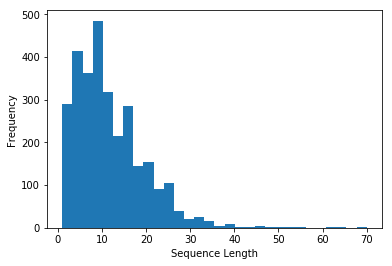

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(counts, 30)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
# plt.axis([0, 1200, 0, 8000])
plt.show()

In [11]:
cleaned_text = [' '.join(tkn) for tkn in tkns]

### Text to integer indices

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

tokenizer = Tokenizer(nb_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(cleaned_text)
sequences = tokenizer.texts_to_sequences(cleaned_text)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

clabels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 5374 unique tokens.
Shape of data tensor: (3000, 15)
Shape of label tensor: (3000,)


/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/keras/preprocessing/text.py:157: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [13]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)


In [14]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
clabels = clabels[indices]

num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

X_train = data[:-num_validation_samples]
Y_train = clabels[:-num_validation_samples]
# Non-hot-encoded labels for sklearn GridSearchCV because it does the hot encoding internally. 
Y_train_orig = labels[:-num_validation_samples]
X_val = data[-num_validation_samples:]
Y_val = clabels[-num_validation_samples:]


In [15]:
Y_train[:, 0].nonzero()[0].shape

(1208,)

### Load pre-existing word embedding the word embeddings

In [16]:
embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

### Our word integer index as look-up in the embedding matrix

In [17]:
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


### Build the Model

In [18]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
## multiclass or binary report
## If binary (sigmoid output), set binary parameter to True
def full_multiclass_report(model,
                           x,
                           y_true,
                           classes,
                           batch_size=32,
                           binary=False):

    # 1. Transform one-hot encoded y_true into their class number
    if not binary:
        y_true = np.argmax(y_true,axis=1)
    
    # 2. Predict classes and stores in y_pred
    y_pred = np.argmax(model.predict(x, batch_size=batch_size), axis=1)
  
    print(y_true.shape, y_pred.shape)
    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true,y_pred)))
    
    print("")
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true,y_pred,digits=5))    
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true,y_pred)
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix,classes=classes)


In [19]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)


In [20]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
X = SpatialDropout1D(0.4)(embedded_sequences)
X = Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.75, return_sequences=True))(X)
# X = Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.75, return_sequences=True))(X)
X = Bidirectional(LSTM(128))(X)
X = Dense(2, activation='softmax')(X)

model = Model(sequence_input, X)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 15)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 15, 300)           1612500   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 15, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 15, 256)           439296    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 2,446,550
Trainable params: 834,050
Non-trainable params: 1,612,500
____________________________________________________________

In [21]:
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])
model.reset_states()

In [22]:
BATCH_SIZE = 32
EPOCHS = 30

history = model.fit(X_train, 
          Y_train, 
          epochs = EPOCHS, 
          validation_data=(X_val, Y_val), 
          batch_size=BATCH_SIZE)


Train on 2400 samples, validate on 600 samples
Epoch 1/30
2400/2400 [==============================] - 6s 2ms/step - loss: 0.6241 - acc: 0.6475 - val_loss: 0.5226 - val_acc: 0.7150
Epoch 2/30
2400/2400 [==============================] - 4s 2ms/step - loss: 0.5551 - acc: 0.7254 - val_loss: 0.4887 - val_acc: 0.7733
Epoch 3/30
2400/2400 [==============================] - 4s 2ms/step - loss: 0.5308 - acc: 0.7421 - val_loss: 0.4522 - val_acc: 0.7633
Epoch 4/30
2400/2400 [==============================] - 4s 2ms/step - loss: 0.5101 - acc: 0.7500 - val_loss: 0.4312 - val_acc: 0.7867
Epoch 5/30
2400/2400 [==============================] - 4s 2ms/step - loss: 0.5010 - acc: 0.7550 - val_loss: 0.4264 - val_acc: 0.7833
Epoch 6/30
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4797 - acc: 0.7683 - val_loss: 0.4221 - val_acc: 0.7867
Epoch 7/30
2400/2400 [==============================] - 4s 2ms/step - loss: 0.4505 - acc: 0.7863 - val_loss: 0.4053 - val_acc: 0.7900
Epoch 8/30
2400

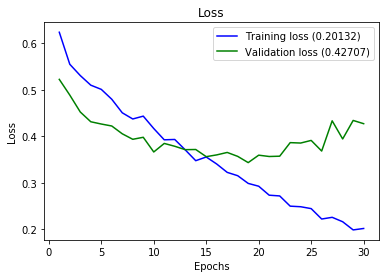

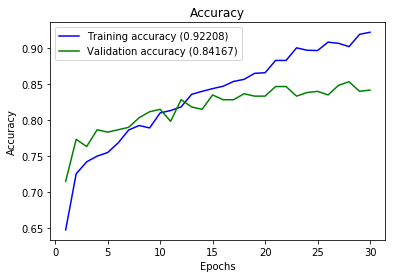

In [23]:
plot_history(history)

(600,) (600,)
Accuracy : 0.8416666666666667

Classification Report
             precision    recall  f1-score   support

          0    0.85560   0.81164   0.83304       292
          1    0.82972   0.87013   0.84945       308

avg / total    0.84231   0.84167   0.84146       600

[[237  55]
 [ 40 268]]


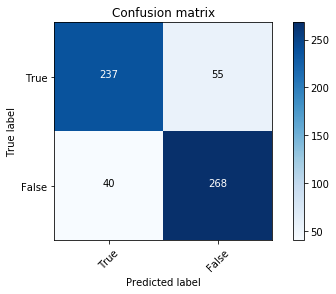

In [24]:
full_multiclass_report(model, X_val, Y_val, np.array(["True", "False"]))

In [25]:
twt = ['This shows poor build quality']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=15, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")


[[   0    0    0    0    0    0    0    0    0    0    8 1013  176 4727
    74]]
negative


In [26]:
model.save('lstm_senti_v0.h5')